In [1]:
import pickle
import json
import numpy as np

random_seed = 42
np.random.seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
data_dir = 'data/'

train_path = data_dir + 'train/'
test_path = data_dir + 'test/'
benign_dir = 'benign/'
malicious_dir = 'malicious/'

In [2]:
import os
binary_vectors_size = 8477

data_dir = 'data/'
preproc_path = data_dir + 'preprocessed/8477_vec_size/'

binary_path = preproc_path + 'binary/'
train_binary_path = binary_path + 'train/'
test_binary_path = binary_path + 'test/'
X_train = []
max_dim = 0
filenames = [train_binary_path + malicious_dir + filename for filename in os.listdir(train_binary_path + malicious_dir)]
for filename in filenames:
    vec_log = np.load(filename)
    max_dim = max(max_dim, vec_log.shape[0])
    X_train.append(vec_log[:,:binary_vectors_size - 4096])
y_train = np.ones(len(X_train))

filenames = [train_binary_path + benign_dir + filename for filename in os.listdir(train_binary_path + benign_dir)]
for filename in filenames:
    vec_log = np.load(filename)
    max_dim = max(max_dim, vec_log.shape[0])
    X_train.append(vec_log[:,:binary_vectors_size - 4096])
    
y_train = np.concatenate([y_train, np.zeros(len(X_train) - len(y_train))])

In [3]:
X_test = []
filenames = [test_binary_path + malicious_dir + filename for filename in os.listdir(test_binary_path + malicious_dir)]
for filename in filenames:
    vec_log = np.load(filename)
    max_dim = max(max_dim, vec_log.shape[0])
    X_test.append(vec_log[:,:binary_vectors_size - 4096])
y_test = np.ones(len(X_test))

filenames = [test_binary_path + benign_dir + filename for filename in os.listdir(test_binary_path + benign_dir)]
for filename in filenames:
    vec_log = np.load(filename)
    max_dim = max(max_dim, vec_log.shape[0])
    X_test.append(vec_log[:,:binary_vectors_size - 4096])
    
y_test = np.concatenate([y_test, np.zeros(len(X_test) - len(y_test))])

In [4]:
max_dim

692

In [5]:

for i in range(len(X_train)):
    X_train[i] = np.pad(X_train[i], ((0,max_dim - X_train[i].shape[0]),(0,0)), 'constant')
    
for i in range(len(X_test)):
    X_test[i] = np.pad(X_test[i], ((0,max_dim - X_test[i].shape[0]),(0,0)), 'constant')


In [6]:
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [ ]:
def get_x_batch(ixs):
    x_batch = []
    for i in ixs:
        with open(graphs_dir + 'alligned/' + str(i) + '.pkl', 'rb') as out_file:
            x = pickle.load(out_file)
        x_batch.append(x)
    return np.stack(x_batch)

In [7]:
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential

In [47]:
from tensorflow.keras.constraints import non_neg
model = Sequential()
model.add(Dense(1024, input_shape=(max_dim, binary_vectors_size - 4096), kernel_constraint=non_neg(), activation='relu'))
model.add(Dense(256, kernel_constraint=non_neg(), activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, kernel_constraint=non_neg(), activation='sigmoid'))


In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 692, 1024)         4487168   
_________________________________________________________________
dense_13 (Dense)             (None, 692, 256)          262400    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 4,749,825
Trainable params: 4,749,825
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = {'loss' : [], 'accuracy' : [], 'val_loss' : [], 'val_accuracy' : []}

In [17]:
batch_size = 32
epochs = 5
iterations = len(train_ixs) // batch_size
print('iterations: ', iterations)
for epoch in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    for i in range(iterations):
        batch = get_x_batch(train_ixs[i * batch_size:i * batch_size + batch_size])
        y_batch = np.asarray([y[j] for j in train_ixs[i * batch_size:i * batch_size + batch_size]])
        lss, acc = model.train_on_batch(batch, y_batch)
        epoch_loss += lss
        epoch_acc += acc
        if (i + 1) % 10 == 0:
            print('epoch {}: {}/{}'.format(epoch, i, iterations))
            print(lss, acc)
    
    if iterations * batch_size != len(train_ixs):
        batch = get_x_batch(train_ixs[iterations * batch_size:])
        y_batch = np.asarray([y[j] for j in train_ixs[iterations * batch_size:]])
        lss, acc = model.train_on_batch(batch, y_batch)
        epoch_loss += lss
        epoch_acc += acc
        #break
    print('loss : {}, accuracy : {}'.format(epoch_loss, epoch_acc))
    history['loss'].append(epoch_loss / (iterations + 1))
    history['accuracy'].append(epoch_acc / (iterations + 1))
    val_lss, val_acc = model.evaluate(get_x_batch(val_ixs), np.asarray([y[j] for j in val_ixs]))
    history['val_loss'].append(val_lss)
    history['val_accuracy'].append(val_acc)

iterations:  44
epoch 0: 9/44
0.56826633 0.90625
epoch 0: 19/44
0.5095586 0.90625
epoch 0: 29/44
0.5305359 0.875
epoch 0: 39/44
0.4373892 0.9375
loss : 23.41669151186943, accuracy : 39.71255272626877
353/353 [==============================] - 20s 55ms/step
epoch 1: 9/44
0.5624147 0.90625
epoch 1: 19/44
0.5007211 0.90625
epoch 1: 29/44
0.5182345 0.875
epoch 1: 39/44
0.43245524 0.90625
loss : 22.97837993502617, accuracy : 39.6488636136055
353/353 [==============================] - 20s 55ms/step
epoch 2: 9/44
0.54320693 0.90625
epoch 2: 19/44
0.49171275 0.90625
epoch 2: 29/44
0.5060756 0.875
epoch 2: 39/44
0.4223973 0.9375
loss : 22.56433457136154, accuracy : 39.8728084564209
353/353 [==============================] - 20s 56ms/step
epoch 3: 9/44
0.5365904 0.90625
epoch 3: 19/44
0.48141992 0.90625
epoch 3: 29/44
0.49574637 0.875
epoch 3: 39/44
0.4157132 0.90625
loss : 22.199216544628143, accuracy : 39.875405848026276
353/353 [==============================] - 19s 54ms/step
epoch 4: 9/44
0.

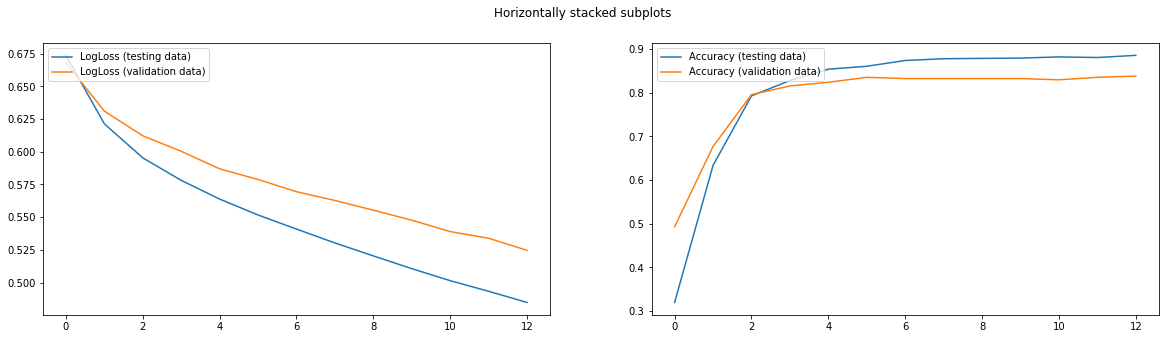

In [22]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(history['loss'][2:], label='LogLoss (testing data)')
ax1.plot(history['val_loss'][2:], label='LogLoss (validation data)')
ax1.legend(loc="upper left")
ax2.plot(history['accuracy'][:-2], label='Accuracy (testing data)')
ax2.plot(history['val_accuracy'][:-2], label='Accuracy (validation data)')
ax2.legend(loc="upper left")
plt.show()

In [23]:
plt.savefig("train_plt_4.png")

<Figure size 432x288 with 0 Axes>

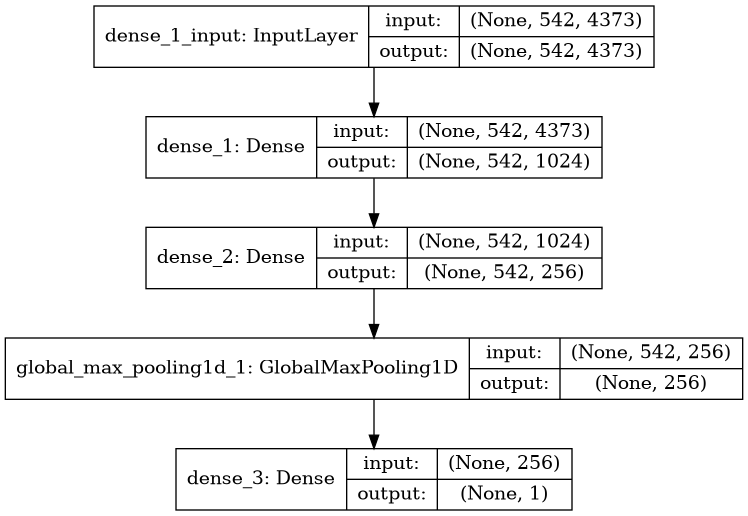

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
scores = model.evaluate(get_x_batch(test_ixs), np.asarray([y[j] for j in test_ixs]), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

442/442 [==============================] - 19s 43ms/step
Accuracy: 84.84%


In [24]:
y_preds = model.predict(get_x_batch(test_ixs), verbose=1)

442/442 [==============================] - 23s 52ms/step
